In [1]:
import matplotlib.pyplot as plt
import numpy as np

'''

Given some guess of the source of direction we can shift the carrier frequency
phase of received samples at the N different receivers. If the guess of the
source direction is correct, the signal from the N different receivers should
interfer constructively.

'''

c=3e8 # speed of light
import sys
sys.path.append("/Users/miskodzamba/Dropbox/research/gits/")
import importlib
import spf.software.model_training_and_inference.utils.rf as rf
importlib.reload(rf)


<module 'spf.software.model_training_and_inference.utils.rf' from '/Users/miskodzamba/Dropbox/research/gits/spf/software/model_training_and_inference/utils/rf.py'>

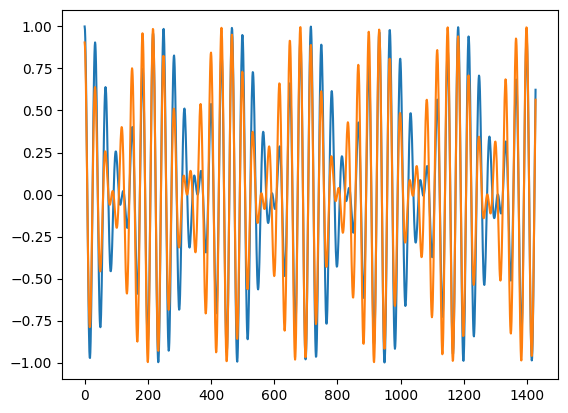

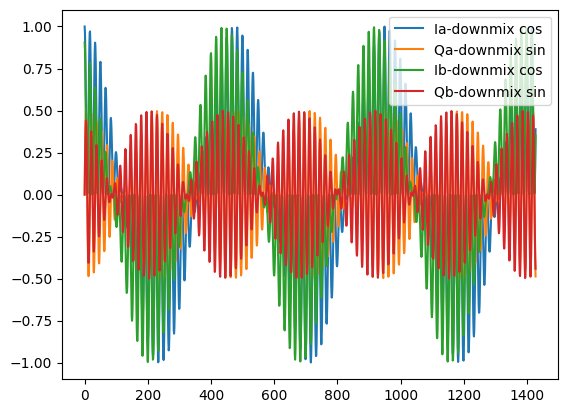

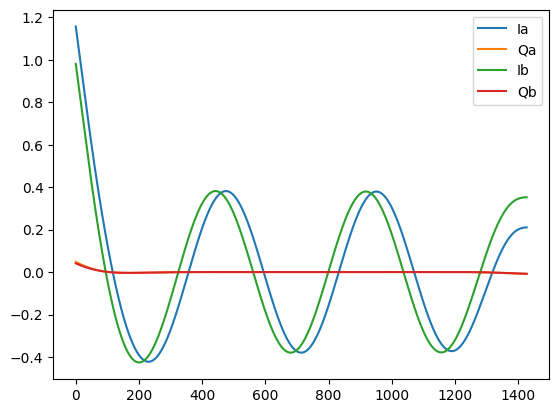

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
fc=100
fs=fc*100 # 100 samples per period
fi=7
lambdac=c/fc
lambdai=c/fi
periodi=1.0/fi
periodc=1.0/fc
samples_per_periodc=int(periodc*fs)
samples_per_periodi=int(periodi*fs)


def signal_at_time(time_offset):
    ts=np.linspace(0,3*periodi,samples_per_periodi)+time_offset
    i=np.cos(2*np.pi*fi*ts)
    q=0
    return i*np.cos(2*np.pi*fc*ts)+q*np.sin(2*np.pi*fc*ts)
    

#lets assume the same signal received
def process_recv(_signal,time_offset=0):
    #time_offset=0 +periodc*0.1 # cannot recover IQ if no phase lock
    ts=np.linspace(0,3*periodi,samples_per_periodi)+time_offset
    _downmix_cos=_signal*np.cos(2*np.pi*fc*(ts))
    _downmix_sin=_signal*np.sin(2*np.pi*fc*(ts))
    b,a=scipy.signal.butter(2,fi*4,btype='low',fs=fs)
    _filt_downmix_cos=scipy.signal.filtfilt(b,a,_downmix_cos)
    _filt_downmix_sin=scipy.signal.filtfilt(b,a,_downmix_sin)
    return {
        'Iraw':_downmix_cos,
        'Qraw':_downmix_sin,
        'I':_filt_downmix_cos,
        'Q':_filt_downmix_sin
    }


#raw signal sent out
fig,ax=plt.subplots(1,1)
signal_senta=signal_at_time(0)
signal_sentb=signal_at_time(periodc)
ax.plot(signal_senta)
ax.plot(signal_sentb)

rsignala=process_recv(signal_senta)
rsignalb=process_recv(signal_sentb)

fig,ax=plt.subplots(1,1)
ax.plot(rsignala['Iraw'],label='Ia-downmix cos')
ax.plot(rsignala['Qraw'],label='Qa-downmix sin')
ax.plot(rsignalb['Iraw'],label='Ib-downmix cos')
ax.plot(rsignalb['Qraw'],label='Qb-downmix sin')
ax.legend()

import scipy
fig,ax=plt.subplots(1,1)
ax.plot(rsignala['I'],label='Ia')
ax.plot(rsignala['Q'],label='Qa')
ax.plot(rsignalb['I'],label='Ib')
ax.plot(rsignalb['Q'],label='Qb')
ax.legend()


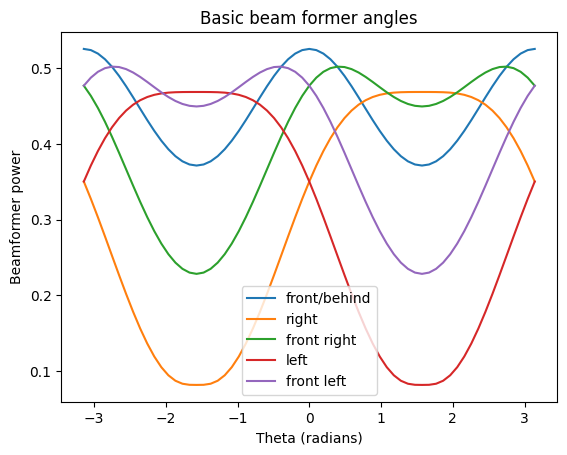

In [35]:

#given coordinates are x+ -> right, not x+ -> left (as is wall setup, then flip)
pos=np.array([
    [-lambdac/8,0], # location of a
    [lambdac/8,0] # locaiton of b
])

max_delay=np.linalg.norm(pos[0]-pos[1])/c

offset_and_label=[
    [(0,0),'front/behind'],
    #[(0,periodc/4),'front left'], # b gets signal before a, 
    [( max_delay,0),'right'],
    [( max_delay/2,0),'front right'], # front right
    [( 0, max_delay),'left'],
    [( 0, max_delay/2),'front left'], # front left
    #[(periodc/4,0),'front right'],
]

for offset,label in offset_and_label:
    #signal b is half a carrier wavelength ahead of signal a
    rsignala=process_recv(signal_at_time(offset[0]))
    rsignalb=process_recv(signal_at_time(offset[1]))
    signal_matrix=np.vstack([
        rsignala['I']+1j*rsignala['Q'],
        rsignalb['I']+1j*rsignalb['Q']])
    thetas,sds,steer=rf.beamformer(
        pos,
        signal_matrix,
        fc)
    plt.plot(thetas,sds,label=label)

plt.title("Basic beam former angles")
plt.ylabel("Beamformer power")
plt.xlabel("Theta (radians)")
plt.legend()
